# Figure 1

This notebook generates the plots for figure 1

- A) Total number of months over 1982-2018 with observations.
- B) Number ofunique months with observations.
- C) Long-term mean pCO$_2$ at each 1°x1°pixel. 
- D) Bias be-tween SOCAT and mean of nine GOBMs.

In [1]:
%matplotlib inline
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format = 'png'
%config InlineBackend.print_figure_kwargs = {'dpi':300, 'bbox_inches': 'tight'}

import numpy as np
import pandas as pd
import xarray as xr
import xarray.ufuncs as xu
import cmocean as cm
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import AutoMinorLocator
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os

# Makes world maps
from plotting_tools.spatial_map import SpatialMap
from plotting_tools.time_series_diagram import TimeSeriesPlot
from plotting_tools.utils import xr_add_cyclic_point

import seaflux

# 0. figures directory

In [2]:
dir_figs = '/home/gloege/projects/ldeo_hpd/reports/figures'

# 1. Load data

## 1.1 Load GCB 2019

In [51]:
ds_mod = xr.open_dataset('/home/gloege/projects/ldeo_hpd/data/simulations/GCB2019-spco2_1x1_mon_198201-201812.nc')

# model names
models = [ 'cesm_spco2_1x1_A', 
           'recom_jra_spco2_1x1_A', 
           'mpi_spco2_1x1_A', 
           'cnrm_spco2_1x1_A',
           'noresm_spco2_1x1_A',
           'planktom_spco2_1x1_A',
           'princeton_spco2_1x1_A',
           'csiro_spco2_1x1_A',
           'ipsl_spco2_1x1_A']

# initialize
ds_mod['model_avg'] = ds_mod['cesm_spco2_1x1_A']*0

# add all the models
for mod in models:
    ds_mod['model_avg'] +=  ds_mod[mod]
    
# average models
ds_mod['model_avg'] =  ds_mod['model_avg']/len(models)

In [ ]:
ds_mod = xr.open_dataset('/local/data/artemis/simulations/GCB/2020models/gcb_load_A_2020.nc', decode_times=False)

# model names, something weird with mpi in gcb2020
models = [ 'cesm_spco2_1x1_A', 
           'csiro_spco2_1x1_A',
           'fesom_spco2_1x1_A',
           'mpi_spco2_1x1_A', 
           'cnrm_spco2_1x1_A',
           'ipsl_spco2_1x1_A',
           'planktom_spco2_1x1_A',
           'noresm_spco2_1x1_A',
           'princeton_spco2_1x1_A',
         ]

# initialize
ds_mod['model_avg'] = ds_mod['cesm_spco2_1x1_A']*0

# add all the models
for mod in models:
    ds_mod['model_avg'] +=  ds_mod[mod]
    
# average models
ds_mod['model_avg'] =  ds_mod['model_avg']/len(models)

# rename variables 
ds_mod = ds_mod.rename({'X':'lon', 'Y':'lat', 'T':'time'})

# convert time to datetime64
dates = pd.date_range(start=f'1958-01T00:00:00.000000000', 
                      end=f'2019-12T00:00:00.000000000',freq='MS')+ np.timedelta64(14, 'D')

ds_mod['time'] = dates

## Load SOCAT (fig_1)

In [5]:
# Load SOCAT
dir_raw = '/local/data/artemis/observations'
ds_soc = xr.open_dataset(f'{dir_raw}/SOCAT/originals/SOCATv2019_tracks_gridded_monthly.nc')
ds_soc = ds_soc.rename({'xlon':'lon', 'ylat':'lat', 'tmnth':'time'})

# time range
date_range = ['1982-01', '2016-12']
ds_soc = ds_soc.sel(time=slice(f'{date_range[0]}',f'{date_range[1]}'))
ds_soc['time'] = pd.date_range(start=f'{date_range[0]}T00:00:00.000000000', 
                               end=f'{date_range[1]}T00:00:00.000000000',freq='MS')+ np.timedelta64(14, 'D')

# convert fco2 to pco2
ds_soc['pco2_ave_unwtd'] = xr.apply_ufunc(
    seaflux.fCO2_to_pCO2, 
    ds_soc['fco2_ave_unwtd'], 
    ds_soc['sst_ave_unwtd'])


# roll longitude
ds_soc = ds_soc.roll(lon=180, roll_coords='lon')
ds_soc['lon'] = np.arange(0.5,360,1)

/home/gloege/.conda/envs/tensorflow/lib/python3.7/site-packages/seaflux/check_units.py:258: RuntimeWarning: invalid value encountered in less
  outside = (arr < lims[0]) | (arr > lims[1])
/home/gloege/.conda/envs/tensorflow/lib/python3.7/site-packages/seaflux/check_units.py:258: RuntimeWarning: invalid value encountered in greater
  outside = (arr < lims[0]) | (arr > lims[1])


## orig load SOCAT

In [3]:
dir_raw = '/local/data/artemis/observations'
ds = xr.open_dataset(f'{dir_raw}/SOCAT/originals/SOCATv2019_tracks_gridded_monthly.nc')
ds = ds.rename({'xlon':'lon', 'ylat':'lat'})
ds = ds.sel(tmnth=slice('1982-01','2018-12'))

In [4]:
# Load SOCAT
#dir_raw = '/local/data/artemis/observations'
#ds = xr.open_dataset(f'{dir_raw}/SOCAT/originals/SOCATv2019_tracks_gridded_monthly.nc')
#ds = ds.rename({'xlon':'lon', 'ylat':'lat'})
#ds = ds.sel(tmnth=slice('1982-01','2018-12'))

#dir_raw = '/local/data/artemis/workspace/gloege/data/SOCAT'
#ds = xr.open_dataset(f'{dir_raw}/SOCATv2020_tracks_gridded_monthly.nc')
#ds = ds.rename({'xlon':'lon', 'ylat':'lat'})
#ds = ds.sel(tmnth=slice('2000-01','2020-12'))

# convert fco2 to pco2
ds['pco2_ave_unwtd'] = xr.apply_ufunc(
    seaflux.fCO2_to_pCO2, 
    ds['fco2_ave_unwtd'], 
    ds['sst_ave_unwtd'])


# roll longitude
ds = ds.roll(lon=180, roll_coords='lon')
ds['lon'] = np.arange(0.5,360,1)

# SOCAT Mask
#ds_mask = xr.open_dataset(f'{dir_raw}/SOCAT/SOCATv5_mask_198201-201701.nc')
#ds_mask = ds_mask.rename({'xlon':'lon', 'ylat':'lat'})

# Number of months with obervations
nmonths = (ds['fco2_ave_unwtd'] > 0).sum('tmnth')
nmonths = nmonths.where(nmonths>0)

/home/gloege/.conda/envs/tensorflow/lib/python3.7/site-packages/seaflux/check_units.py:258: RuntimeWarning: invalid value encountered in less
  outside = (arr < lims[0]) | (arr > lims[1])
/home/gloege/.conda/envs/tensorflow/lib/python3.7/site-packages/seaflux/check_units.py:258: RuntimeWarning: invalid value encountered in greater
  outside = (arr < lims[0]) | (arr > lims[1])


## Unique months with data

In [41]:
unique_months = (ds_soc['fco2_ave_unwtd'] > 0).groupby('time.month').max('time').sum('month')

## Number of months with data

In [13]:
# Number of months with obervations
nmonths = (ds_soc['fco2_ave_unwtd'] > 0).sum('time')
nmonths = nmonths.where(nmonths>0)

## SOCAT mask

In [44]:
mask = (ds_soc['pco2_ave_unwtd']>0)*1

# SOCAT Mean

<Figure size 1920x1320 with 0 Axes>

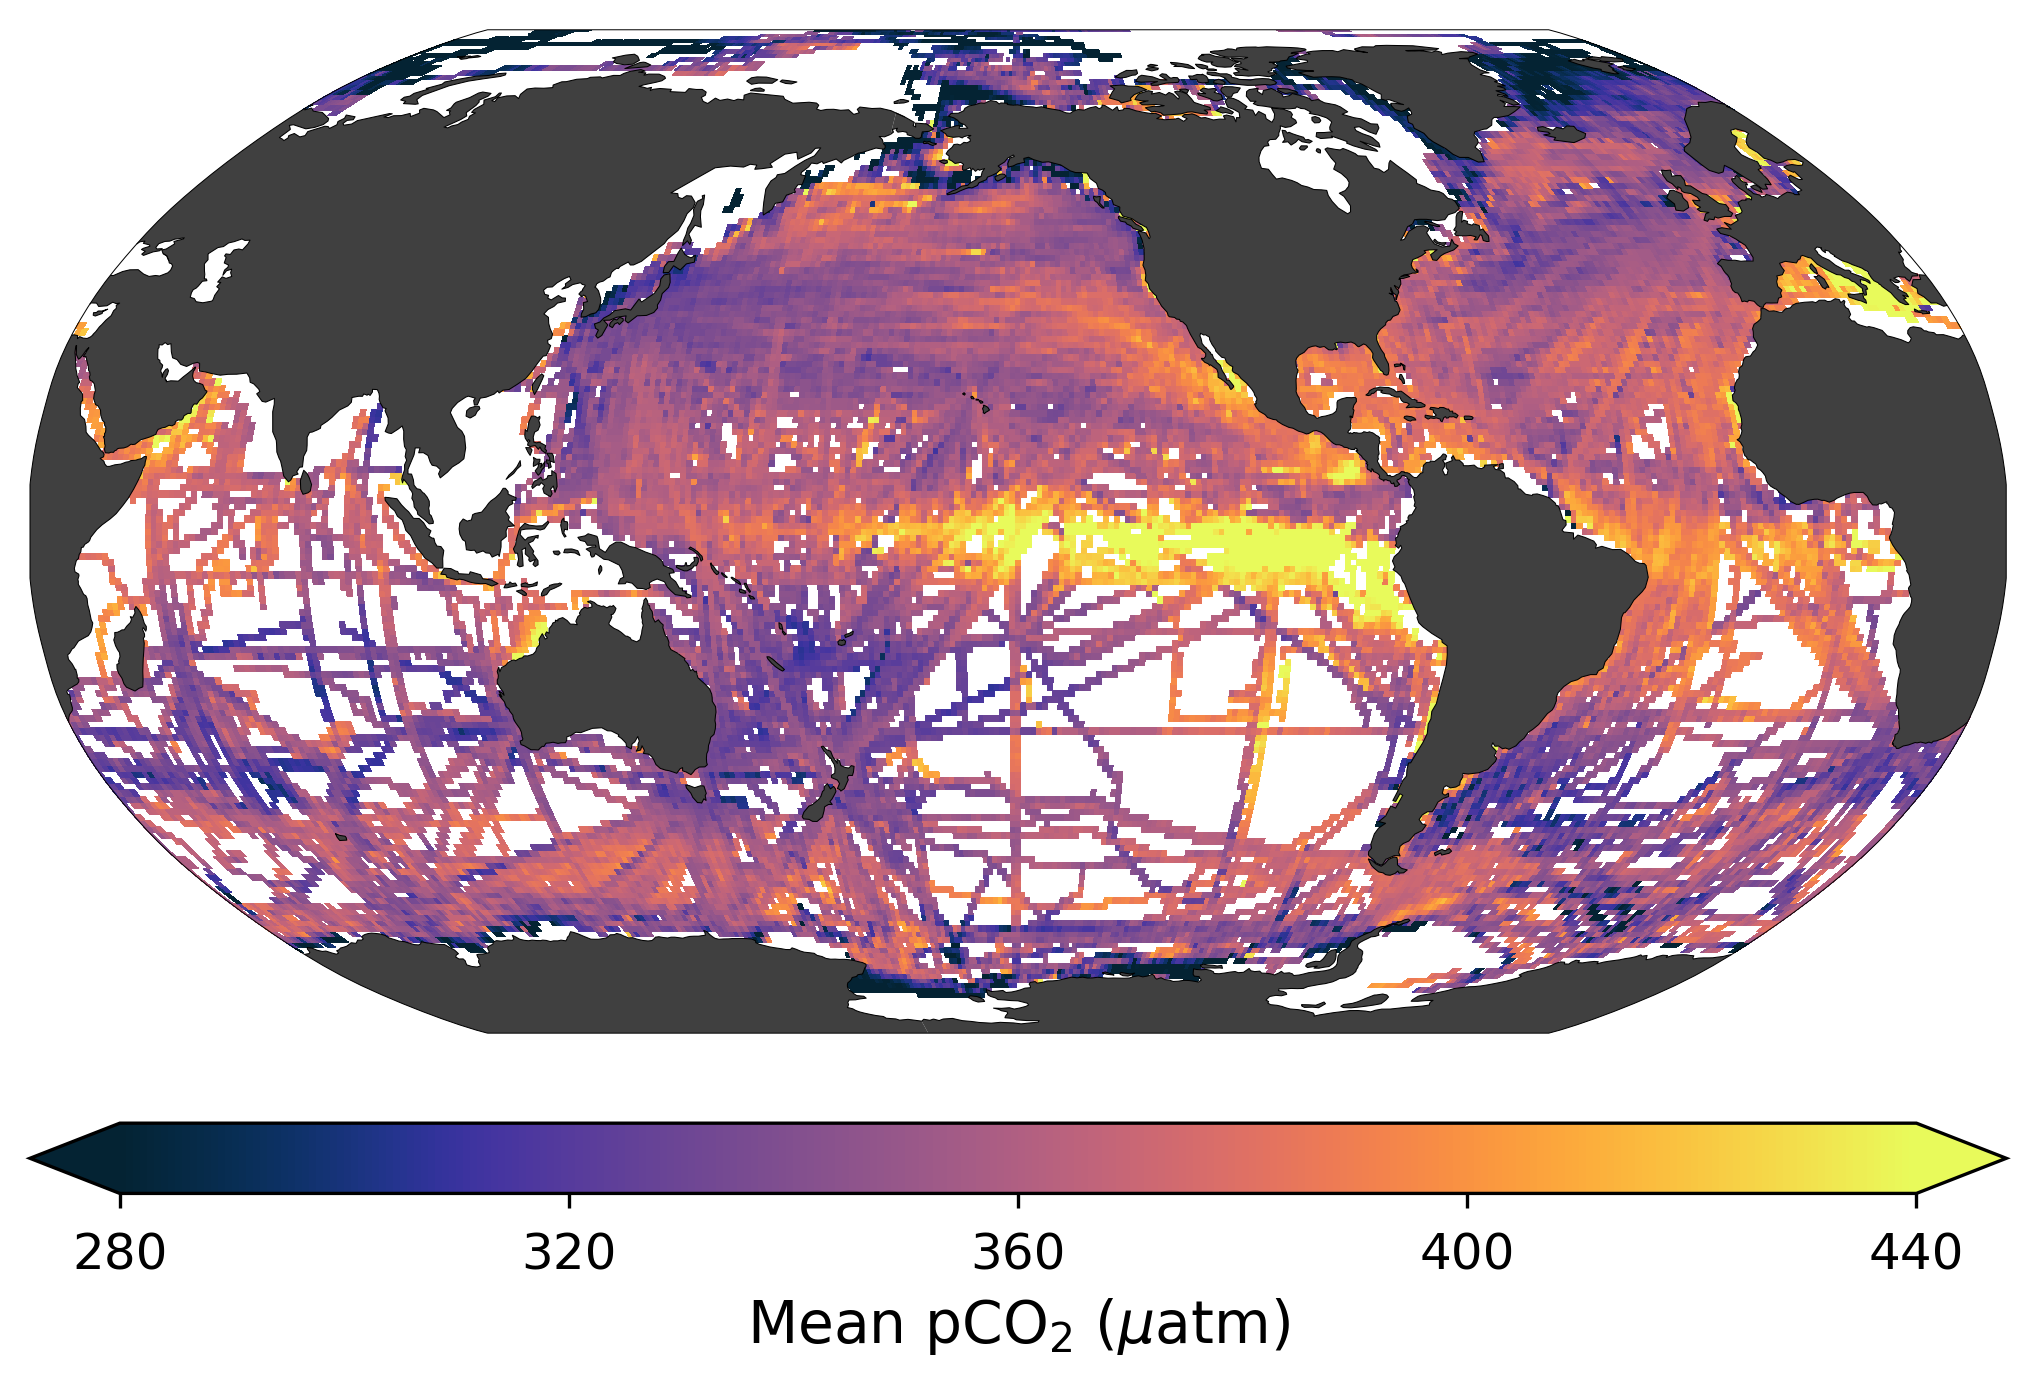

In [11]:
# colormap

vrange = [280, 440, 40]
cmap = cm.cm.thermal

# data to plot
data = ds_soc['pco2_ave_unwtd'].sel(time=slice('1982-01','2017-12')).mean('time')
data = xr_add_cyclic_point(data, cyclic_coord='lon') 

# make figure
with plt.style.context('seaborn-paper'):
    fig = plt.figure(dpi=300, facecolor='w')
    dia = SpatialMap(cbar_location='bottom', cbar_orientation='horizontal')
    sub = dia.add_plot(lat = data['lat'], 
                       lon = data['lon'], 
                       data = data, 
                       vrange=vrange[0:2], 
                       cmap=cmap, 
                       ax=0)
    
    col = dia.add_colorbar(sub, ax=0, extend='both')
    col.ax.tick_params(labelsize=12)
    dia.set_cbar_xlabel(col, 'Mean pCO$_2$ ($\mu$atm)', fontsize=14)
    col.set_ticks(ticks=np.arange(vrange[0], vrange[1]+vrange[2], vrange[2]))

    #plt.savefig(f'{dir_figs}/socat_mean_pco2_1982-2017.pdf', 
    #            transparent = True, 
    #            bbox_inches = 'tight', 
    #            pad_inches = 0)

# Months with observations

<Figure size 1920x1320 with 0 Axes>

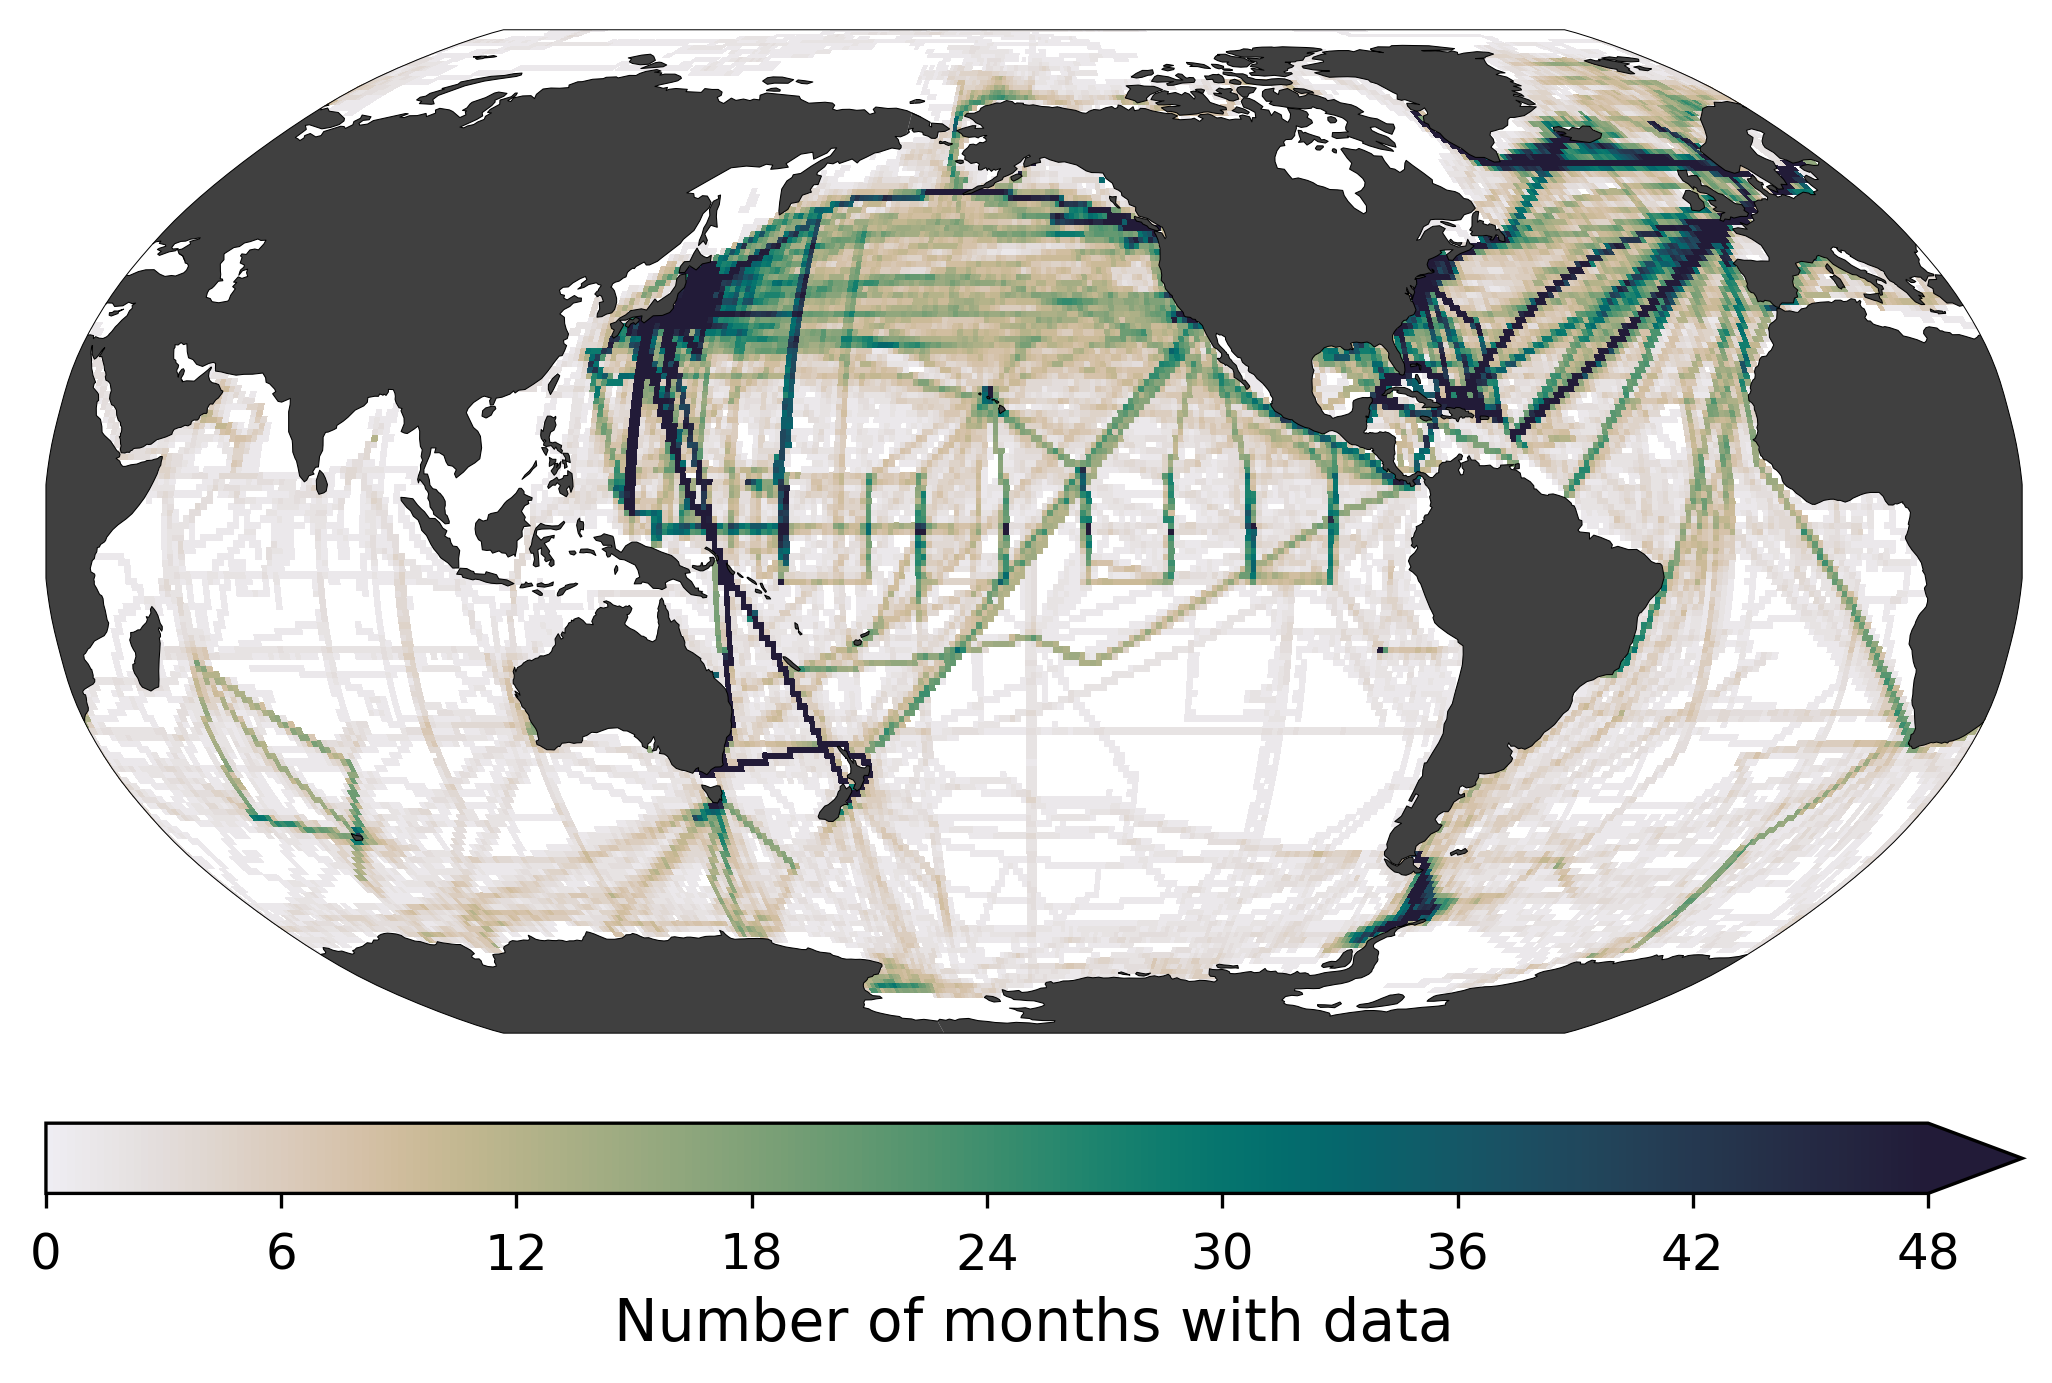

In [14]:
# colormap
vrange = [0, 48, 6]
cmap = cm.cm.rain

# data to plot
data = nmonths
data = xr_add_cyclic_point(data, cyclic_coord='lon') 

# make figure
with plt.style.context('seaborn-paper'):
    fig = plt.figure(dpi=300)
    dia = SpatialMap(cbar_location='bottom', cbar_orientation='horizontal')
    sub = dia.add_plot(lat = data['lat'], 
                       lon = data['lon'], 
                       data = data, 
                       vrange=vrange[0:2], 
                       cmap=cmap, 
                       ax=0)
    col = dia.add_colorbar(sub, ax=0, extend='max')
    col.ax.tick_params(labelsize=12)
    dia.set_cbar_xlabel(col, 'Number of months with data', fontsize=14)
    col.set_ticks(ticks=np.arange(vrange[0], vrange[1]+vrange[2], vrange[2]))
    
    #plt.savefig(f'{dir_figs}/socat_number_months_1982-2017.pdf', 
    #            transparent = True, 
    #            bbox_inches = 'tight', 
    #            pad_inches = 0)

# Unique months

<Figure size 1920x1320 with 0 Axes>

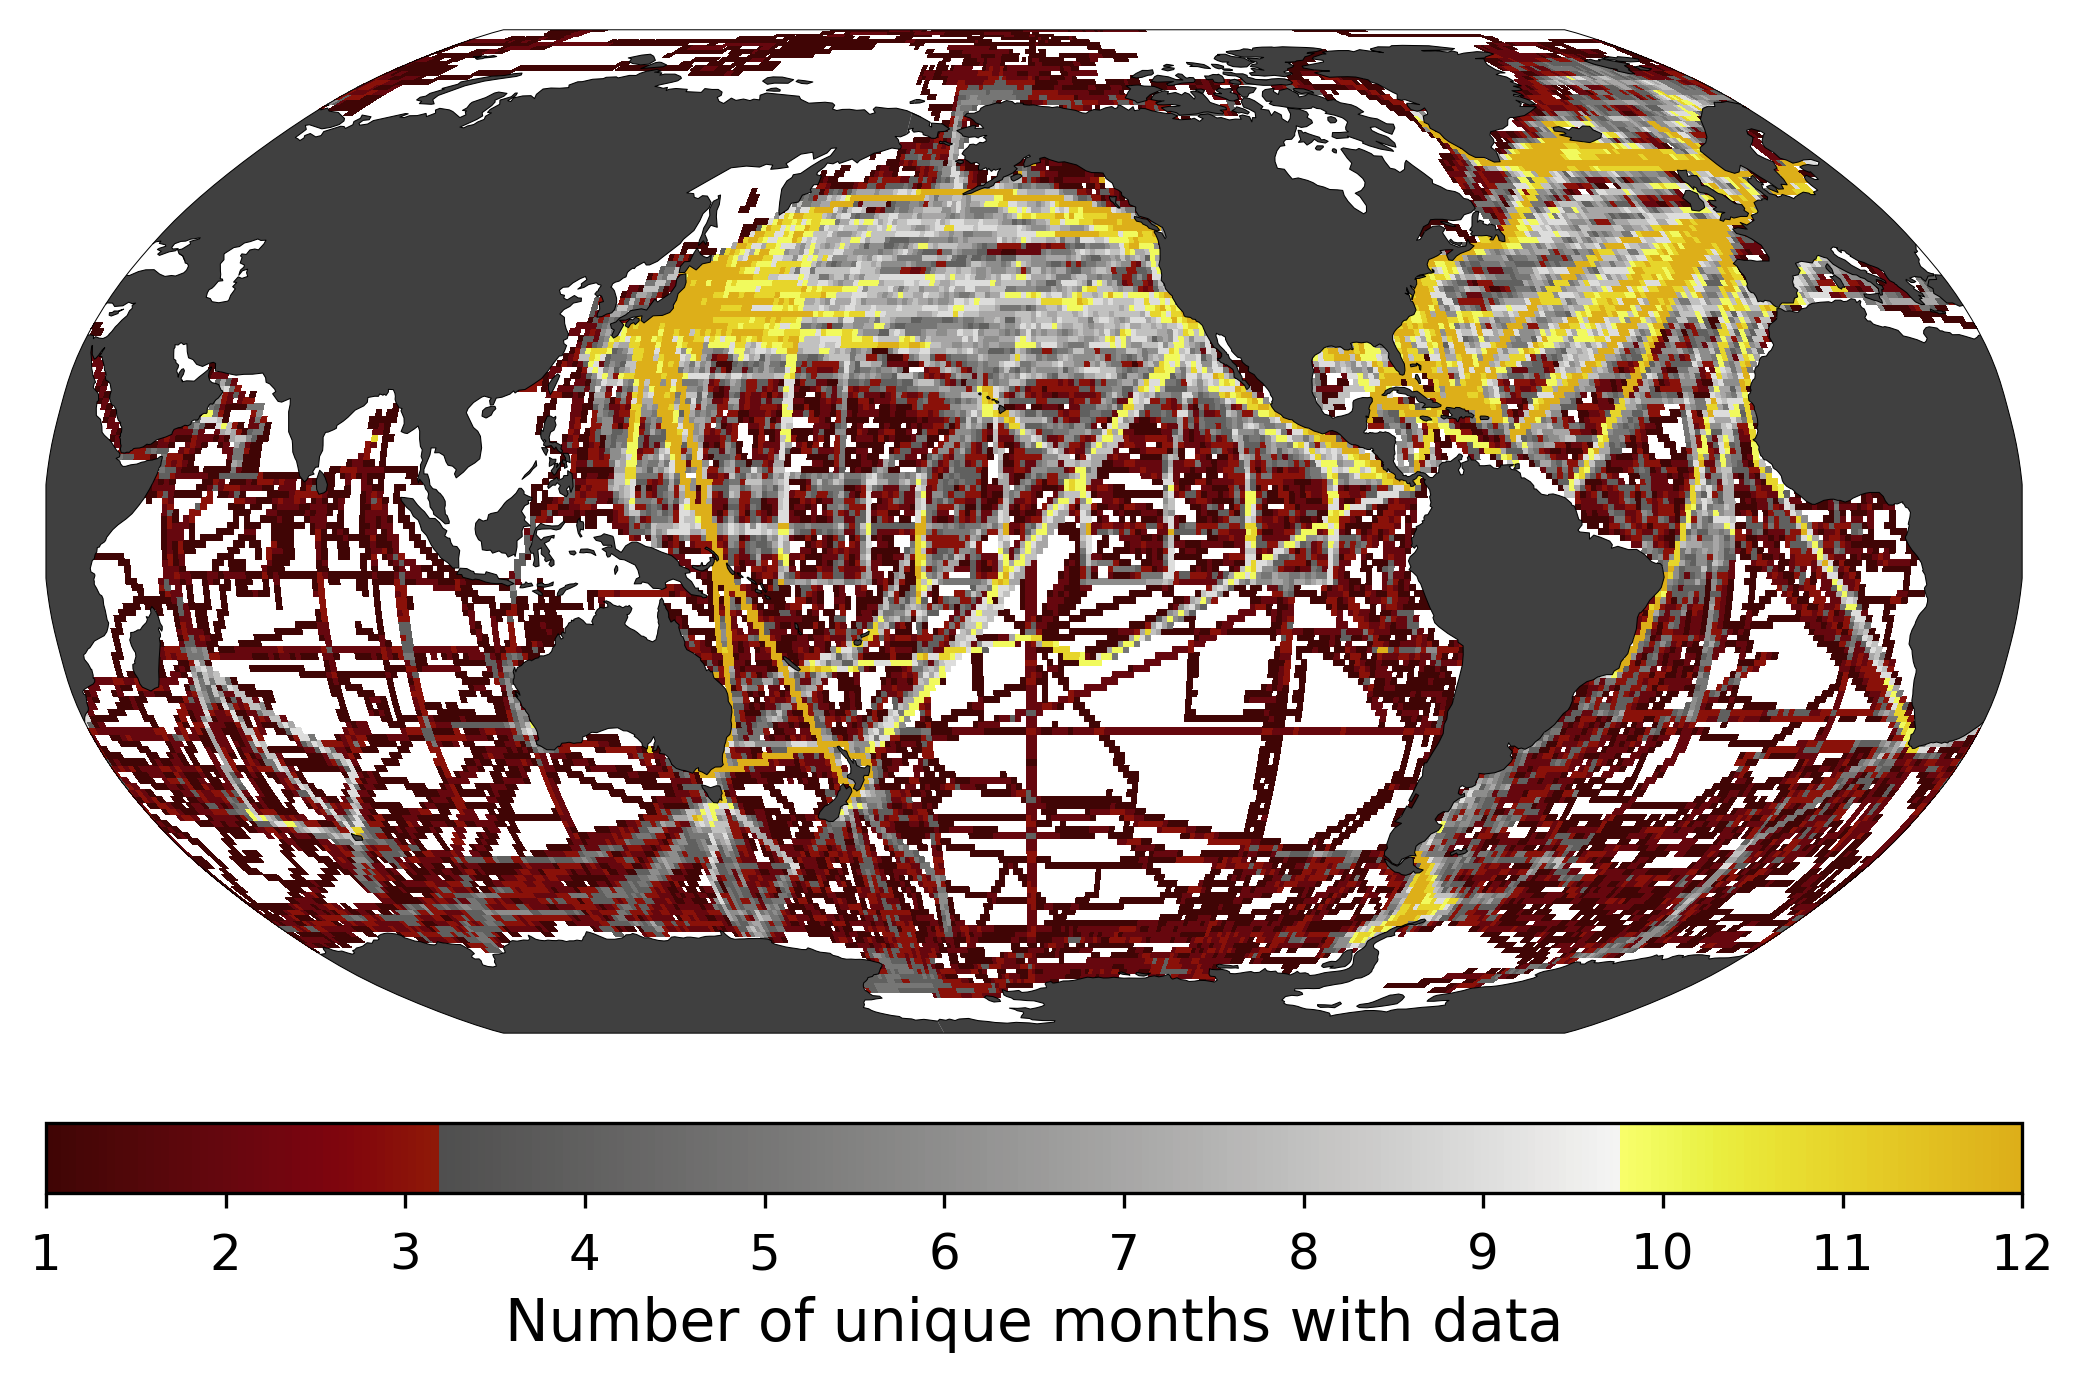

In [42]:
# colormap
vrange = [1, 12, 1]
cmap = cm.cm.oxy

# data to plot
data = unique_months.where(unique_months>0)
data = xr_add_cyclic_point(data, cyclic_coord='lon') 

# make figure
with plt.style.context('seaborn-paper'):
    fig = plt.figure(dpi=300)
    dia = SpatialMap(cbar_location='bottom', cbar_orientation='horizontal')
    sub = dia.add_plot(lat = data['lat'], 
                       lon = data['lon'], 
                       data = data, 
                       vrange=vrange[0:2], 
                       cmap=cmap, 
                       ax=0)
    col = dia.add_colorbar(sub, ax=0)
    col.ax.tick_params(labelsize=12)
    dia.set_cbar_xlabel(col, 'Number of unique months with data', fontsize=14)
    col.set_ticks(ticks=np.arange(vrange[0], vrange[1]+vrange[2], vrange[2]))
    
    #plt.savefig(f'{dir_figs}/socat_unique_months_1982-2017.pdf', 
    #            transparent = True, 
    #            bbox_inches = 'tight', 
    #            pad_inches = 0)

# Difference

/home/gloege/.conda/envs/tensorflow/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


<Figure size 1920x1320 with 0 Axes>

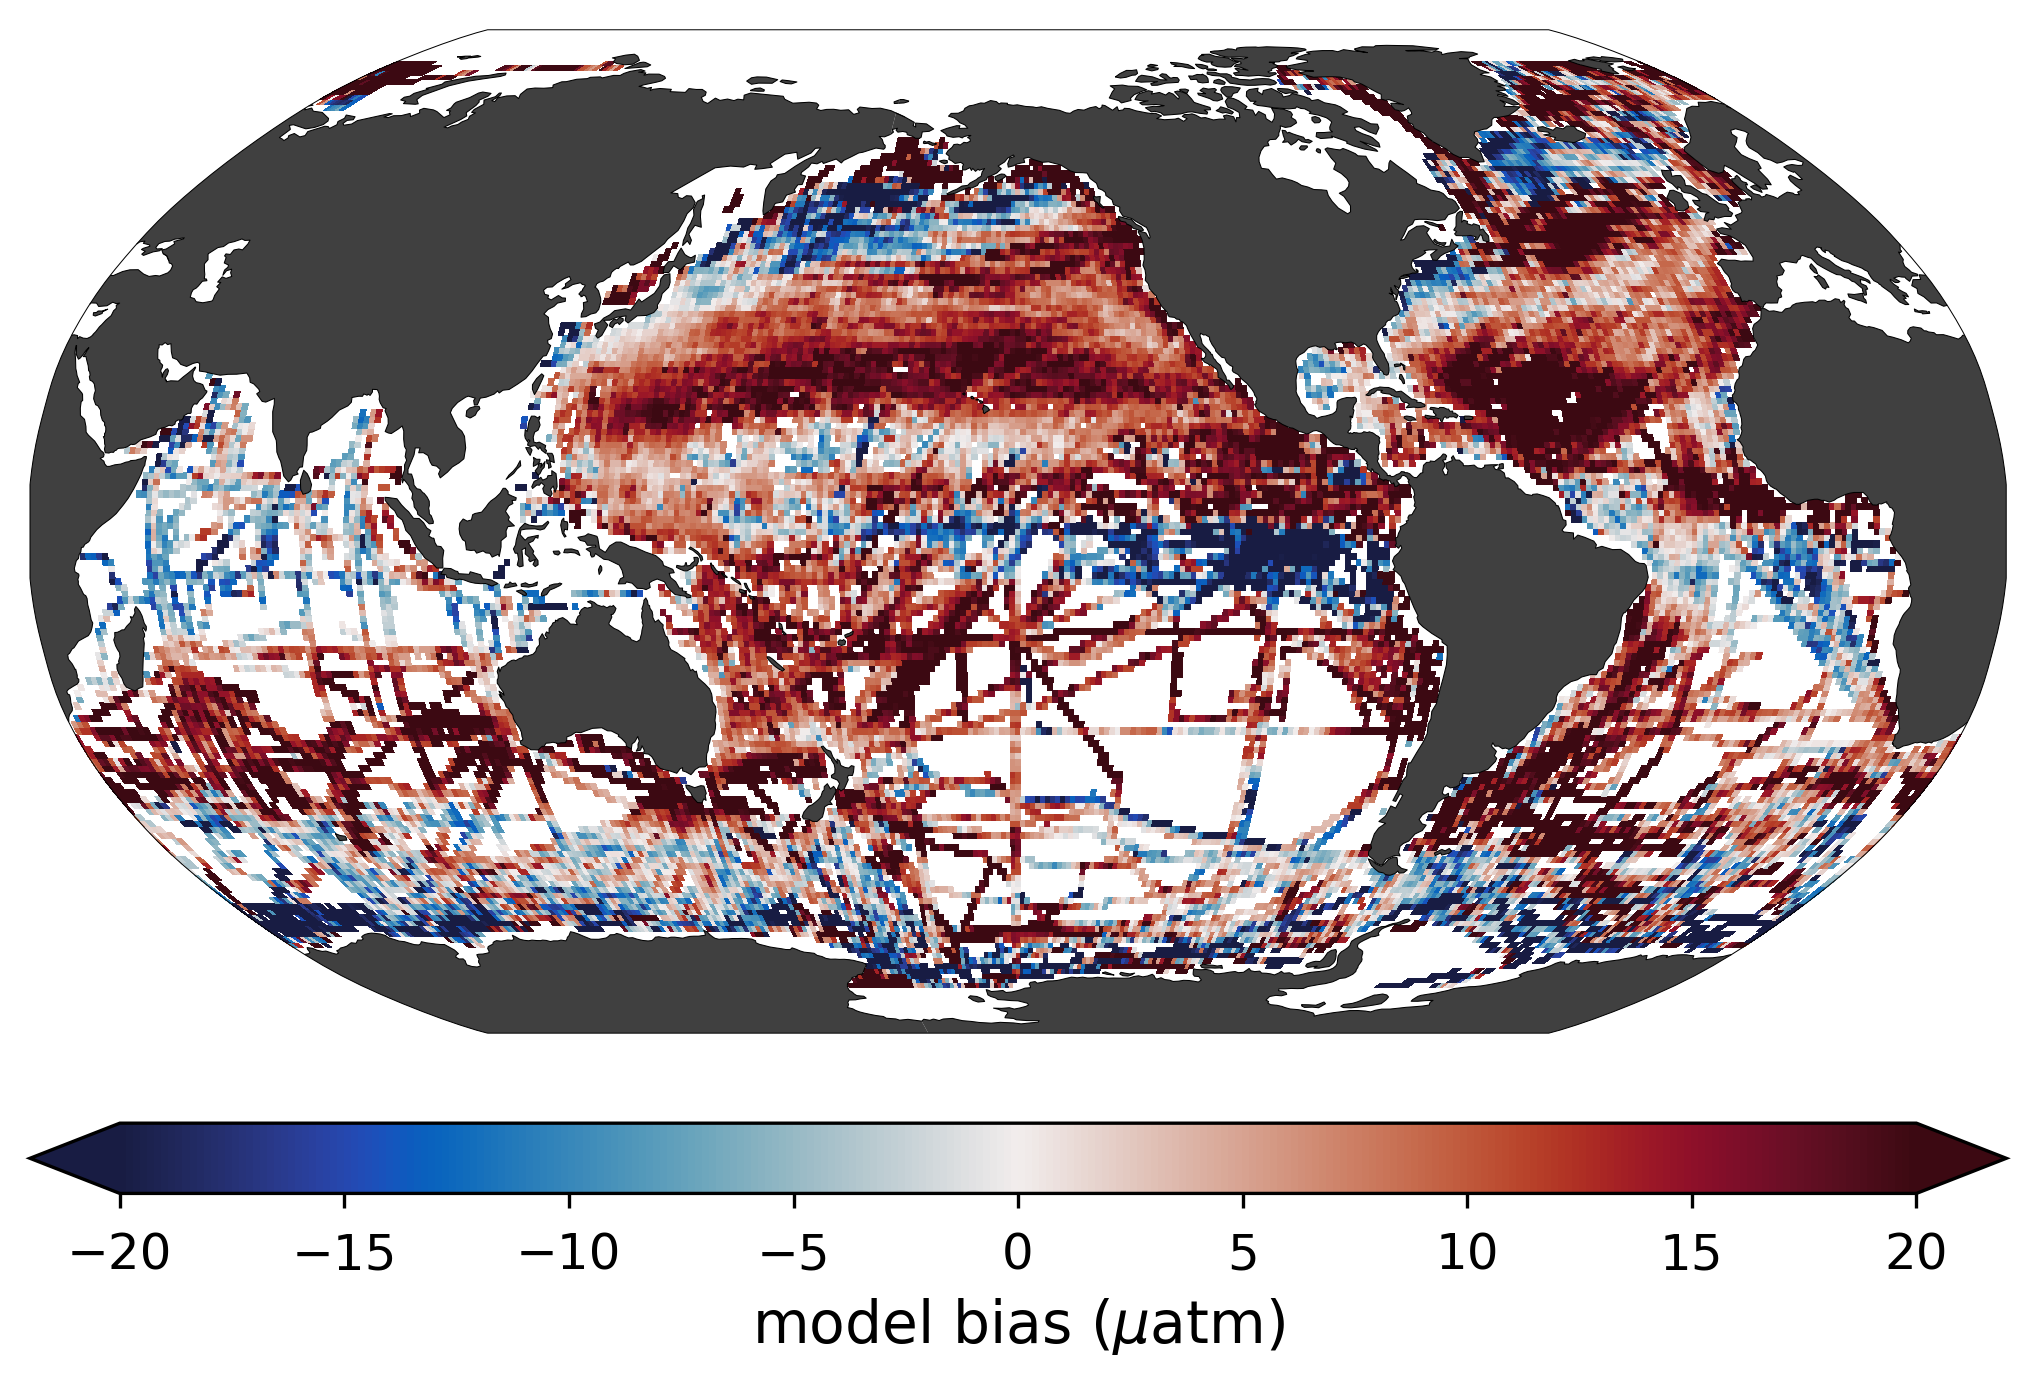

In [52]:
socat = ds_soc.sel(time=slice('1982-01','2016-12'))
model = ds_mod.sel(time=slice('1982-01','2016-12'))
socat_mask = mask.sel(time=slice('1982-01','2016-12'))

bias = model['model_avg'].where(socat_mask==1).mean('time') - socat['pco2_ave_unwtd'].mean('time')

# colormap
vrange = [-20, 20, 5]
cmap = cm.cm.balance

# data to plot
data = bias
data = xr_add_cyclic_point(data, cyclic_coord='lon') 

# make figure
with plt.style.context('seaborn-paper'):
    fig = plt.figure(dpi=300)
    dia = SpatialMap(cbar_location='bottom', cbar_orientation='horizontal')
    sub = dia.add_plot(lat = data['lat'], 
                       lon = data['lon'], 
                       data = data, 
                       vrange=vrange[0:2], 
                       cmap=cmap, 
                       ax=0)
    
    col = dia.add_colorbar(sub, ax=0, extend='both')
    col.ax.tick_params(labelsize=12)
    dia.set_cbar_xlabel(col, 'model bias ($\mu$atm)', fontsize=14)
    col.set_ticks(ticks=np.arange(vrange[0], vrange[1]+vrange[2], vrange[2]))
    
    #plt.savefig(f'{dir_figs}/modeal_bias_from_socat_1982-2017.pdf', 
    #            transparent = True, 
    #            bbox_inches = 'tight', 
    #            pad_inches = 0)

# Number data points

In [54]:
nobs = (ds_soc['fco2_ave_unwtd'] > 0)

nobs_NH = (ds_soc['fco2_ave_unwtd'] > 0).sel(lat=slice(0,90))
nobs_SH = (ds_soc['fco2_ave_unwtd'] > 0).sel(lat=slice(-90,0))

years = np.unique(nobs['time.year'])

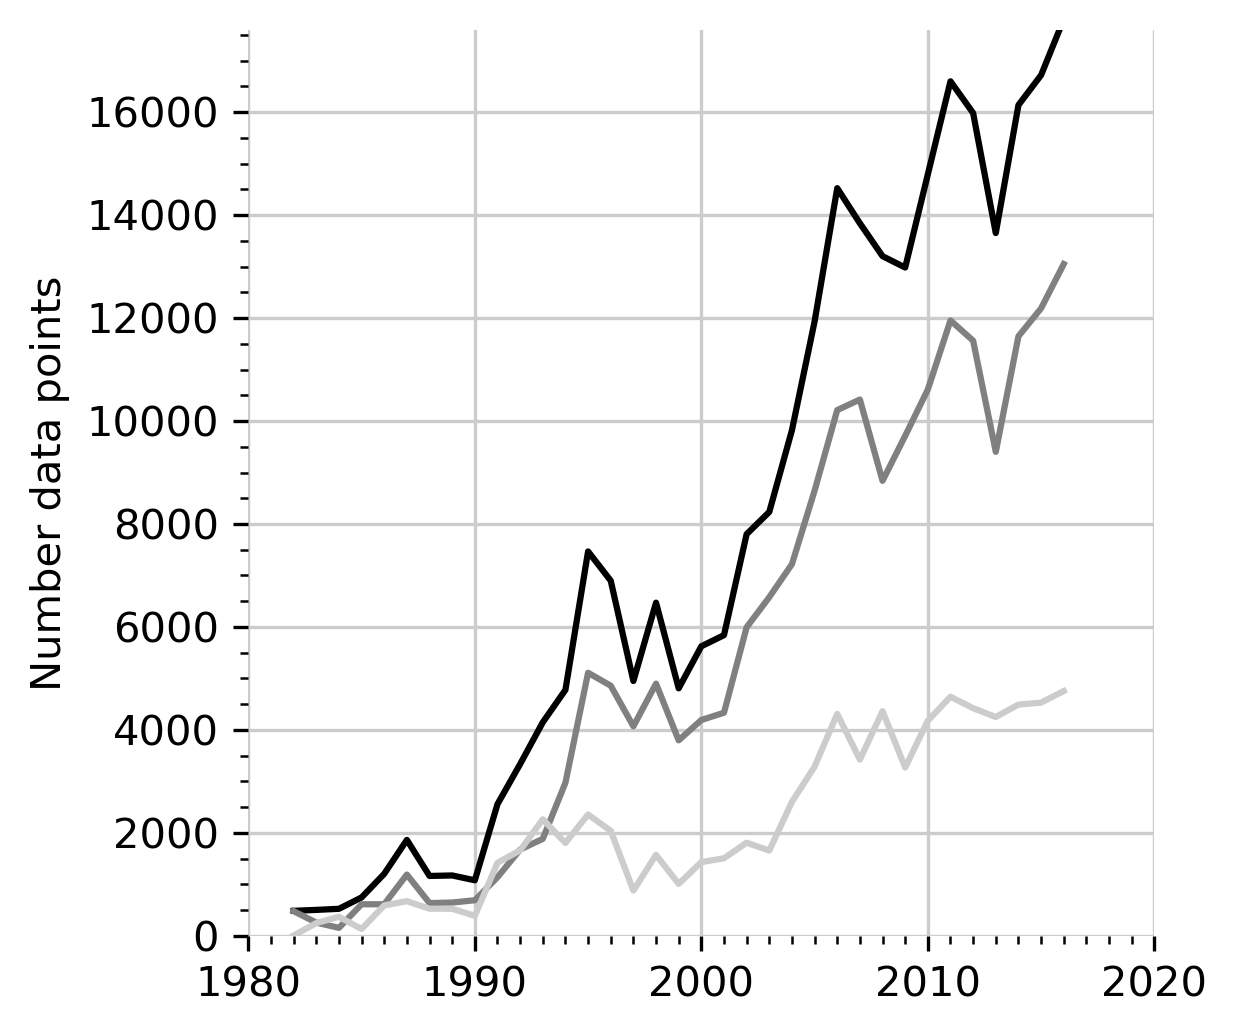

In [56]:
fig = plt.figure(dpi=300) 
ax = fig.add_subplot(111)

# axis limits
#ax_lims = [0, 0.25, 0.05]

# lats and stat
#lats = [-90,-35]
#stat = 'dec'

# one-to-one line
ax.plot([0,10],[0,10],'--', color=[0.8,0.8,0.8])
 
colors = {'CESM':'#DF8E5B',      # light blue
          'MPI':'#A16EA5',   # dark blue
          'GFDL':'#A3C7F3',      # light green
          'CanESM':'#102A83'}       # dark green

#-------------------------
# Plot data
#-------------------------
# plot scatter
ax.plot(years,nobs.sum(['lon', 'lat']).groupby('time.year').sum('time'), color=[0,0,0]) #s=10, label=model, c=colors[model])
    
ax.plot(years,nobs_NH.sum(['lon', 'lat']).groupby('time.year').sum('time'), color=[0.5,0.5,0.5]) #s=10, label=model, c=colors[model])
ax.plot(years,nobs_SH.sum(['lon', 'lat']).groupby('time.year').sum('time'), color=[0.8,0.8,0.8]) #s=10, label=model, c=colors[model])


# ***********************************************************************
# Figures settings are below here
# ***********************************************************************
# Labels
ax.set_ylabel('Number data points')
ax.set_xlabel('')

# axis limits
#ax.set_xticks(np.arange(ax_lims[0], ax_lims[1]+ax_lims[2], ax_lims[2]))
#ax.set_yticks(np.arange(ax_lims[0], ax_lims[1]+ax_lims[2], ax_lims[2]))

# Set limts
ax.set_ylim([0, 17600])
ax.set_xlim([1980, 2020])

# Turn on the minor ticks, Turn off the display of all ticks.
ax.tick_params(which='both',  # Options for both major and minor ticks
                top='off',    # turn off top ticks
                left='off',   # turn off left ticks
                right='off',  # turn off right ticks
                bottom='off') # turn off bottom ticks

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# X ticks
#ax.tick_params(axis='x', which='both', length=0) # removes x ticks
ax.xaxis.set_minor_locator(AutoMinorLocator(10))
ax.grid(axis='x', which='major', color=[0.8,0.8,0.8], linestyle='-')

# Y ticks
#ax.minorticks_on()
ax.yaxis.set_minor_locator(AutoMinorLocator(4))
ax.grid(axis='y', which='major', color=[0.8,0.8,0.8], linestyle='-')

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

# Make axis square
x0, x1 = ax.get_xlim()
y0, y1 = ax.get_ylim()
ax.set_aspect(abs(x1-x0)/abs(y1-y0))

# Don't allow the axis to be on top of your data
ax.set_axisbelow(True)

# add legend
#leg = ax.legend(frameon=False)

#plt.savefig(f'{dir_figs}/socat_number_data_points_1982-2017.pdf', 
#                transparent = True, 
#                bbox_inches = 'tight', 
#                pad_inches = 0)